# Loss Masking in SFT

**Why we only compute loss on response tokens**

## The Problem

In SFT, our training data looks like:

```
[INSTRUCTION TOKENS] [RESPONSE TOKENS]
```

If we compute loss on ALL tokens, the model learns to predict the instruction too. But we don't want that! The instruction is given by the user — the model should only learn to generate good responses.

**Loss masking** sets the loss to zero for instruction tokens, so the model only learns from response tokens.

## Mathematical Formulation

Without masking:
$$\mathcal{L} = -\sum_{t=1}^{T} \log P(x_t | x_{<t})$$

With masking:
$$\mathcal{L} = -\sum_{t=t_{\text{response}}}^{T} \log P(x_t | x_{<t})$$

where $t_{\text{response}}$ is the token position where the response begins.

In [1]:
import torch
import torch.nn.functional as F

def create_loss_mask(input_ids: torch.Tensor, response_start: int) -> torch.Tensor:
    """
    Create a mask that is 1 for response tokens and 0 for prompt tokens.
    
    Args:
        input_ids: Token IDs, shape (batch_size, seq_len)
        response_start: Token position where response begins
    
    Returns:
        Mask tensor, shape (batch_size, seq_len)
    """
    batch_size, seq_len = input_ids.shape
    mask = torch.zeros(batch_size, seq_len)
    
    # Set mask to 1 for response tokens (from response_start onwards)
    mask[:, response_start:] = 1.0
    
    return mask

# Example
batch_size, seq_len = 2, 10
response_start = 6

input_ids = torch.randint(0, 1000, (batch_size, seq_len))
mask = create_loss_mask(input_ids, response_start)

print("Input shape:", input_ids.shape)
print("Mask:")
print(mask[0])
print("\nMask visualization (0=prompt, 1=response):")
print("Position:", list(range(seq_len)))
print("Mask:    ", mask[0].int().tolist())

Input shape: torch.Size([2, 10])
Mask:
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])

Mask visualization (0=prompt, 1=response):
Position: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Mask:     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


In [2]:
def compute_sft_loss(
    logits: torch.Tensor,
    labels: torch.Tensor,
    loss_mask: torch.Tensor
) -> torch.Tensor:
    """
    Compute SFT loss with masking.
    
    Args:
        logits: Model outputs, shape (batch_size, seq_len, vocab_size)
        labels: Target token IDs, shape (batch_size, seq_len)
        loss_mask: Mask for loss computation, shape (batch_size, seq_len)
    
    Returns:
        Scalar loss value
    """
    # Shift for next-token prediction
    # logits[:, :-1] predicts labels[:, 1:]
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = labels[:, 1:].contiguous()
    shift_mask = loss_mask[:, 1:].contiguous()
    
    # Flatten for cross-entropy
    batch_size, seq_len, vocab_size = shift_logits.shape
    flat_logits = shift_logits.view(-1, vocab_size)
    flat_labels = shift_labels.view(-1)
    flat_mask = shift_mask.view(-1)
    
    # Compute per-token loss
    per_token_loss = F.cross_entropy(
        flat_logits, 
        flat_labels, 
        reduction='none'
    )
    
    # Apply mask and average
    masked_loss = per_token_loss * flat_mask
    loss = masked_loss.sum() / (flat_mask.sum() + 1e-8)
    
    return loss

# Example
batch_size, seq_len, vocab_size = 2, 10, 1000
response_start = 6

logits = torch.randn(batch_size, seq_len, vocab_size)
labels = torch.randint(0, vocab_size, (batch_size, seq_len))
loss_mask = create_loss_mask(labels, response_start)

loss = compute_sft_loss(logits, labels, loss_mask)
print(f"Loss: {loss.item():.4f}")

Loss: 7.8391


## Why Masking Matters

Without loss masking:
- Model learns to predict instructions (waste of capacity)
- May memorize specific instruction phrasings
- Gradient signal diluted across instruction tokens

With loss masking:
- Model focuses entirely on generating good responses
- More efficient use of model capacity
- Stronger gradient signal for response generation

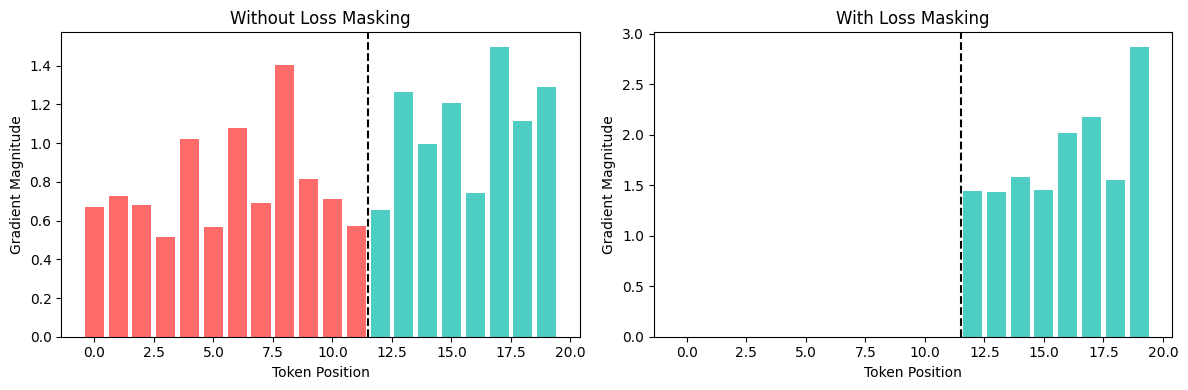

Red = Prompt tokens, Teal = Response tokens
With masking, all gradient signal goes to response tokens!


In [3]:
# Visualization: Compare gradients with and without masking
import matplotlib.pyplot as plt
import numpy as np

seq_len = 20
response_start = 12

# Simulated gradient magnitudes
no_mask_grads = np.random.uniform(0.5, 1.5, seq_len)  # All tokens contribute
masked_grads = np.zeros(seq_len)
masked_grads[response_start:] = np.random.uniform(0.5, 1.5, seq_len - response_start) * 2  # Response only, stronger

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Without masking
colors = ['#ff6b6b' if i < response_start else '#4ecdc4' for i in range(seq_len)]
axes[0].bar(range(seq_len), no_mask_grads, color=colors)
axes[0].set_title('Without Loss Masking')
axes[0].set_xlabel('Token Position')
axes[0].set_ylabel('Gradient Magnitude')
axes[0].axvline(x=response_start-0.5, color='black', linestyle='--', label='Response start')

# With masking
axes[1].bar(range(seq_len), masked_grads, color=colors)
axes[1].set_title('With Loss Masking')
axes[1].set_xlabel('Token Position')
axes[1].set_ylabel('Gradient Magnitude')
axes[1].axvline(x=response_start-0.5, color='black', linestyle='--', label='Response start')

plt.tight_layout()
plt.show()

print("Red = Prompt tokens, Teal = Response tokens")
print("With masking, all gradient signal goes to response tokens!")

## Handling Variable-Length Batches

In practice, each example has a different response start position:

In [4]:
def create_loss_mask_batch(
    input_ids: torch.Tensor,
    response_starts: list[int],
    pad_token_id: int
) -> torch.Tensor:
    """
    Create loss mask for a batch with variable response start positions.
    Also masks out padding tokens.
    """
    batch_size, seq_len = input_ids.shape
    mask = torch.zeros(batch_size, seq_len)
    
    for i, start in enumerate(response_starts):
        # Mask response tokens (1 = compute loss)
        mask[i, start:] = 1.0
        
        # Mask out padding (0 = ignore)
        padding_mask = (input_ids[i] == pad_token_id)
        mask[i] = mask[i] * (~padding_mask).float()
    
    return mask

# Example with variable response starts
batch_size, seq_len = 3, 15
pad_token_id = 0

# Simulate input with padding
input_ids = torch.randint(1, 1000, (batch_size, seq_len))
input_ids[0, 12:] = pad_token_id  # First example padded at position 12
input_ids[1, 14:] = pad_token_id  # Second example padded at position 14
# Third example: no padding

response_starts = [5, 7, 6]  # Different response start for each example

mask = create_loss_mask_batch(input_ids, response_starts, pad_token_id)

print("Loss masks for batch:")
for i in range(batch_size):
    print(f"Example {i}: {mask[i].int().tolist()}")
    print(f"  Response starts at: {response_starts[i]}")

Loss masks for batch:
Example 0: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
  Response starts at: 5
Example 1: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
  Response starts at: 7
Example 2: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  Response starts at: 6


## Using HuggingFace's Built-in Support

The `labels` field in HuggingFace models uses `-100` to indicate tokens that should be ignored in loss computation:

In [5]:
def prepare_labels_for_hf(
    input_ids: torch.Tensor,
    response_start: int
) -> torch.Tensor:
    """
    Prepare labels for HuggingFace models.
    Set prompt tokens to -100 (ignored in loss).
    """
    labels = input_ids.clone()
    labels[:, :response_start] = -100  # Ignore prompt tokens
    return labels

# Example
input_ids = torch.tensor([[101, 102, 103, 104, 105, 201, 202, 203]])
response_start = 5

labels = prepare_labels_for_hf(input_ids, response_start)

print("Input IDs:", input_ids[0].tolist())
print("Labels:   ", labels[0].tolist())
print("\n-100 means 'ignore this token in loss computation'")

Input IDs: [101, 102, 103, 104, 105, 201, 202, 203]
Labels:    [-100, -100, -100, -100, -100, 201, 202, 203]

-100 means 'ignore this token in loss computation'


## Next Steps

Now that we understand loss masking, let's put it all together in a complete SFT training loop.